Gerekli Kütüphaneler yükleniyor

In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
import os

Kaggle sitesi üzerinden veri seti indiriliyor ve dosya yolu belirleniyor

In [2]:
import kagglehub

path = kagglehub.dataset_download("tolgadincer/labeled-chest-xray-images")

print("Path to dataset files:", path)

100%|██████████| 1.17G/1.17G [00:21<00:00, 59.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/tolgadincer/labeled-chest-xray-images/versions/1


Veri Yolunu alıyoruz

In [3]:
data_dir = "/root/.cache/kagglehub/datasets/tolgadincer/labeled-chest-xray-images/versions/1/chest_xray/train/NORMAL"

Veri seti içerisinden rastgele 9 görüntüyü ekrana getiriyoruz

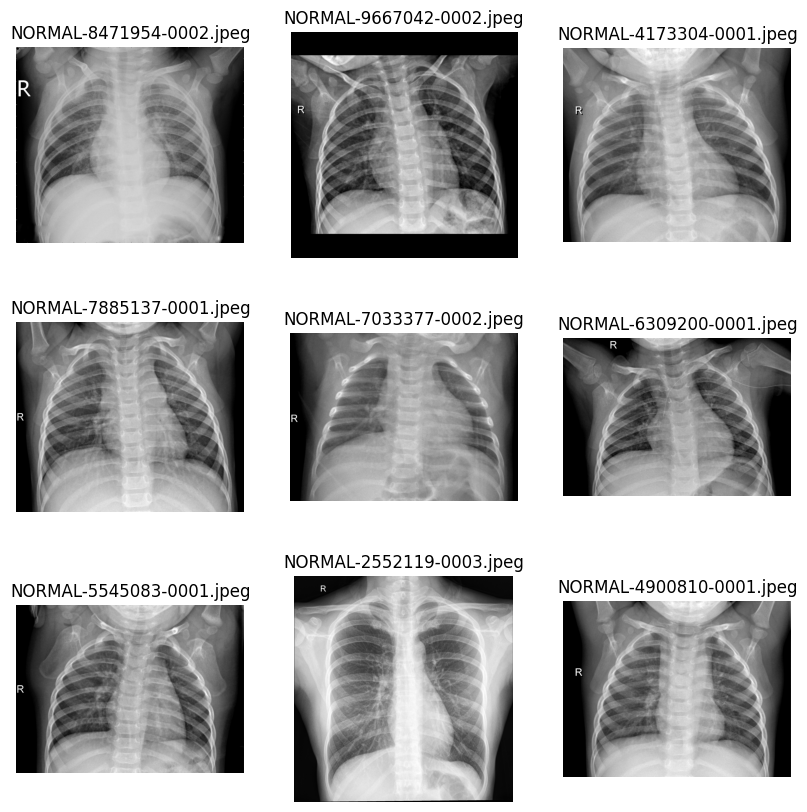

In [5]:
all_images = [f for f in os.listdir(data_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

sample_images = random.sample(all_images, 9)

fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for img_name, ax in zip(sample_images, axes.ravel()):
    img_path = os.path.join(data_dir, img_name)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    ax.imshow(img, cmap='gray')
    ax.axis("off")
    ax.set_title(img_name)

plt.show()

Seçilen görüntülerin crop işlemleri için bir fonksiyon yazılıyor.
Kırpma işlemi %80 oranına göre yapılıyor.
Sonrasında görüntüler yazdırılıyor.

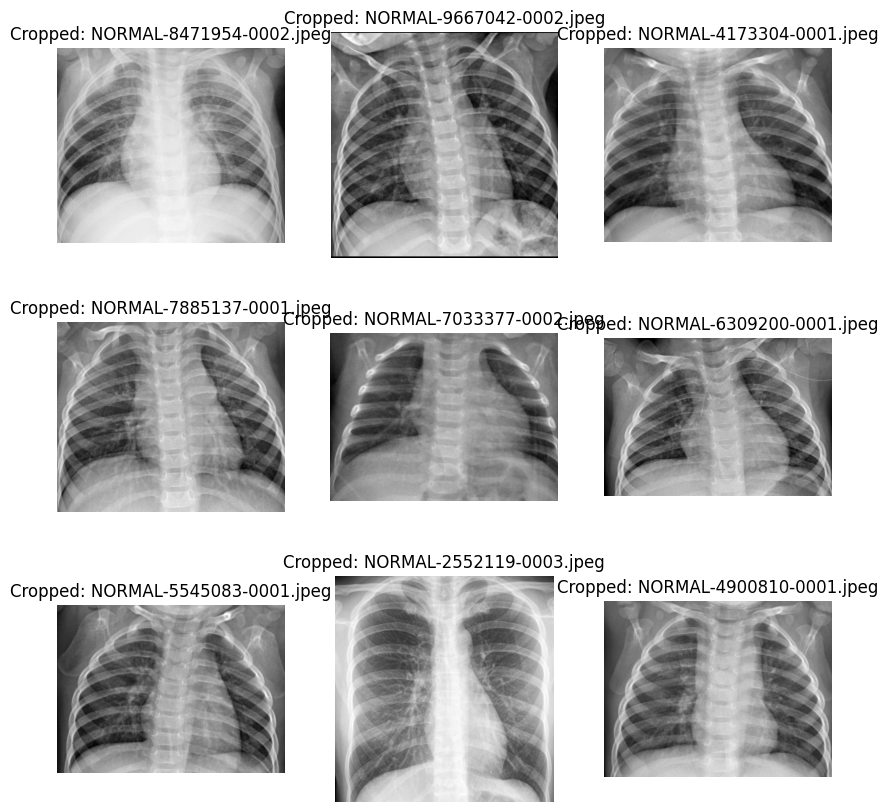

In [6]:
def crop_fixed_percentage(image, crop_percentage=0.8):
    """ Görüntüyü belirlenen yüzdeye göre merkezden crop eder """
    height, width = image.shape[:2]

    new_height = int(height * crop_percentage)
    new_width = int(width * crop_percentage)

    center_y, center_x = height // 2, width // 2

    start_x = max(center_x - new_width // 2, 0)
    start_y = max(center_y - new_height // 2, 0)
    end_x = min(center_x + new_width // 2, width)
    end_y = min(center_y + new_height // 2, height)

    cropped_image = image[start_y:end_y, start_x:end_x]
    return cropped_image

fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for img_name, ax in zip(sample_images, axes.ravel()):
    img_path = os.path.join(data_dir, img_name)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    cropped_img = crop_fixed_percentage(img, crop_percentage=0.8)

    ax.imshow(cropped_img, cmap='gray')
    ax.axis("off")
    ax.set_title(f"Cropped: {img_name}")

plt.show()


Kırpılmış Görüntülere Histogram Eşitleme ve Kontrast Germe işlemleri uygulanıyor.

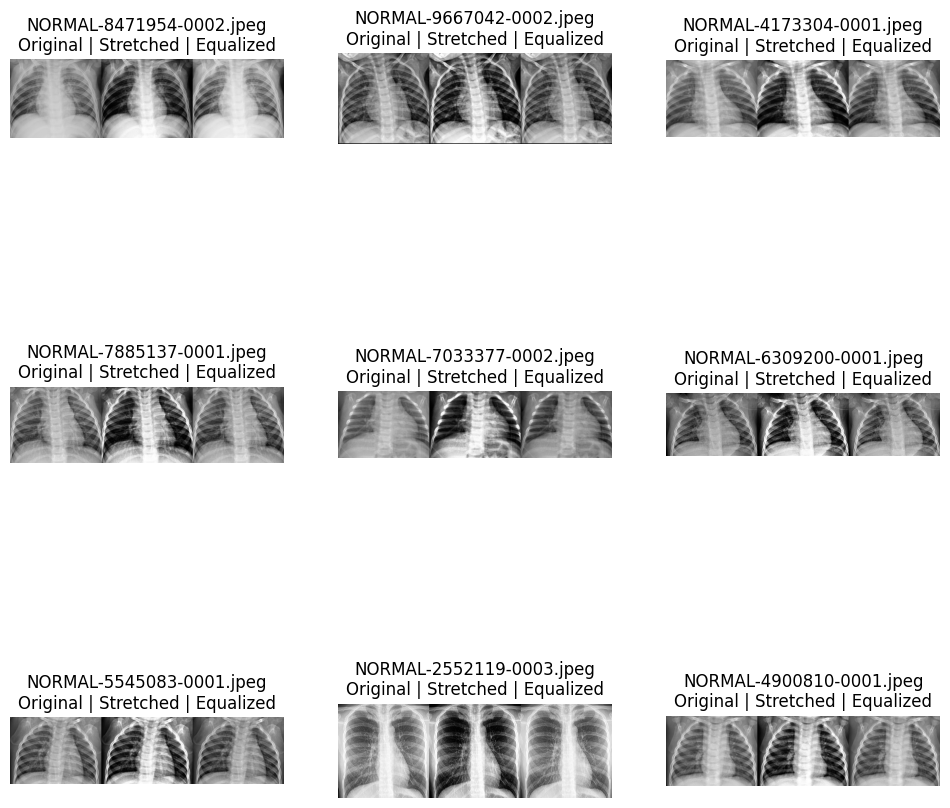

In [8]:
def apply_histogram_equalization(image):
    """ Histogram eşitleme uygular """
    return cv2.equalizeHist(image)

def apply_contrast_stretching(image):
    min_val = np.min(image)
    max_val = np.max(image)
    stretched_image = ((image - min_val) / (max_val - min_val)) * 255
    stretched_image = stretched_image.astype(np.uint8)
    return stretched_image

fig, axes = plt.subplots(3, 3, figsize=(12, 12))

for img_name, ax in zip(sample_images, axes.ravel()):
    img_path = os.path.join(data_dir, img_name)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    cropped_img = crop_fixed_percentage(img, crop_percentage=0.8)

    hist_eq_img = apply_histogram_equalization(cropped_img)

    stretched_img = apply_contrast_stretching(cropped_img)

    ax.imshow(np.hstack([cropped_img, hist_eq_img, stretched_img]), cmap='gray')
    ax.axis("off")
    ax.set_title(f"{img_name}\nOriginal | Stretched | Equalized")

plt.show()


Histogram Eşitleme işlemi yapılan görüntü üzerine Gaussian ve Median Blur işlemleri uygulanıyor.

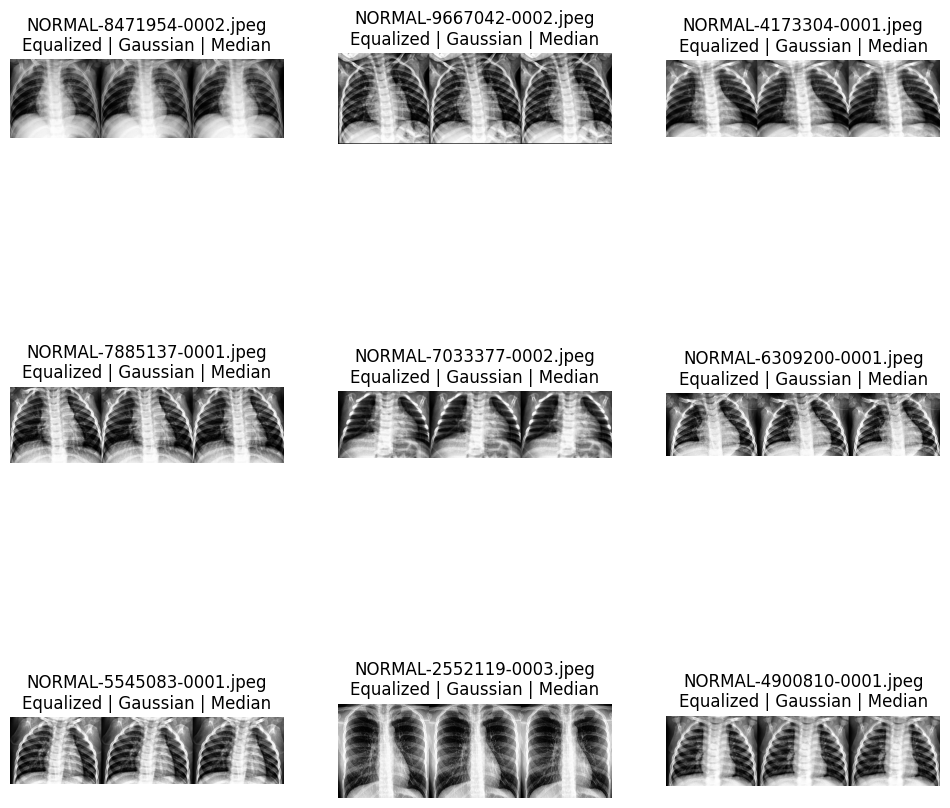

In [9]:
def apply_blur_filters(image):
    """ Gaussian ve Median Blur uygula """
    gaussian_blur = cv2.GaussianBlur(image, (5, 5), 0)
    median_blur = cv2.medianBlur(image, 5)
    return gaussian_blur, median_blur

fig, axes = plt.subplots(3, 3, figsize=(12, 12))

for img_name, ax in zip(sample_images, axes.ravel()):
    img_path = os.path.join(data_dir, img_name)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    cropped_img = crop_fixed_percentage(img, crop_percentage=0.8)

    hist_eq_img = apply_histogram_equalization(cropped_img)

    gaussian_blur, median_blur = apply_blur_filters(hist_eq_img)

    ax.imshow(np.hstack([hist_eq_img, gaussian_blur, median_blur]), cmap='gray')
    ax.axis("off")
    ax.set_title(f"{img_name}\nEqualized | Gaussian | Median")

plt.show()


Global ve OTSU Treshold işlemleri uygulanıyor.
Global de sabit eşik seçilirken OTSU da otomatik seçiliyor.

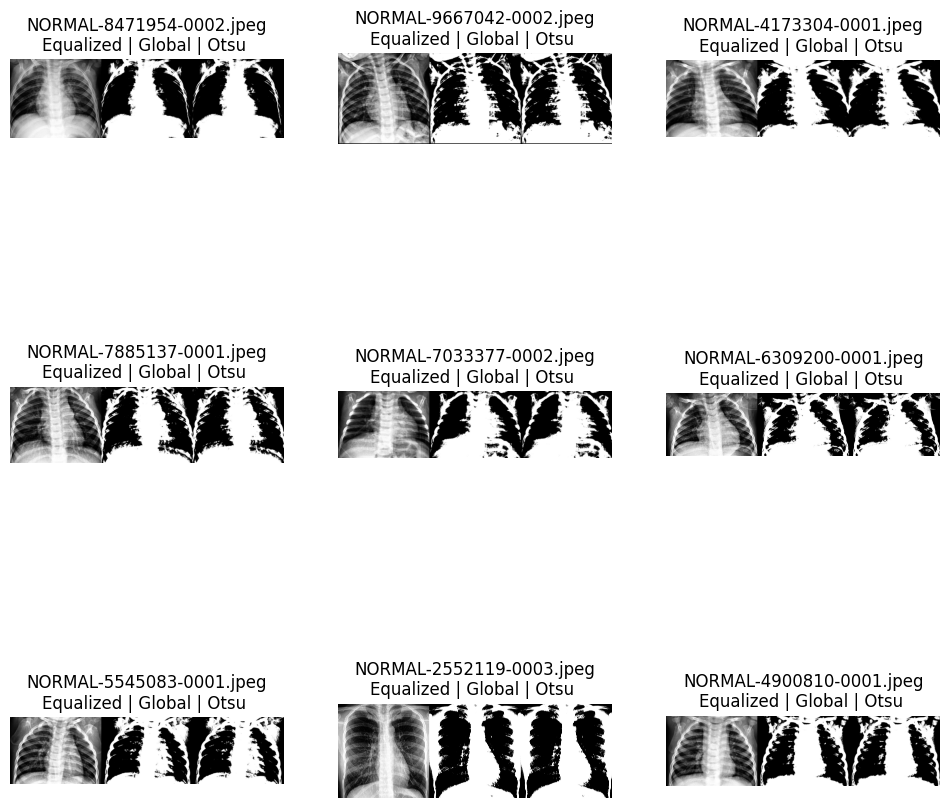

In [19]:
def apply_thresholding(image):
    """ Global, Otsu Thresholding uygular """
    _, global_thresh = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

    _, otsu_thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    return global_thresh, otsu_thresh

fig, axes = plt.subplots(3, 3, figsize=(12, 12))

for img_name, ax in zip(sample_images, axes.ravel()):
    img_path = os.path.join(data_dir, img_name)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    cropped_img = crop_fixed_percentage(img, crop_percentage=0.8)

    hist_eq_img = apply_histogram_equalization(cropped_img)

    global_thresh, otsu_thresh = apply_thresholding(hist_eq_img)

    ax.imshow(np.hstack([hist_eq_img, global_thresh, otsu_thresh]), cmap='gray')
    ax.axis("off")
    ax.set_title(f"{img_name}\nEqualized | Global | Otsu ")

plt.show()


Morfolojik İşlemler uygulanıyor.
Erosion, Dilation, Opening ve Closing işlemleri uygulanıyor.

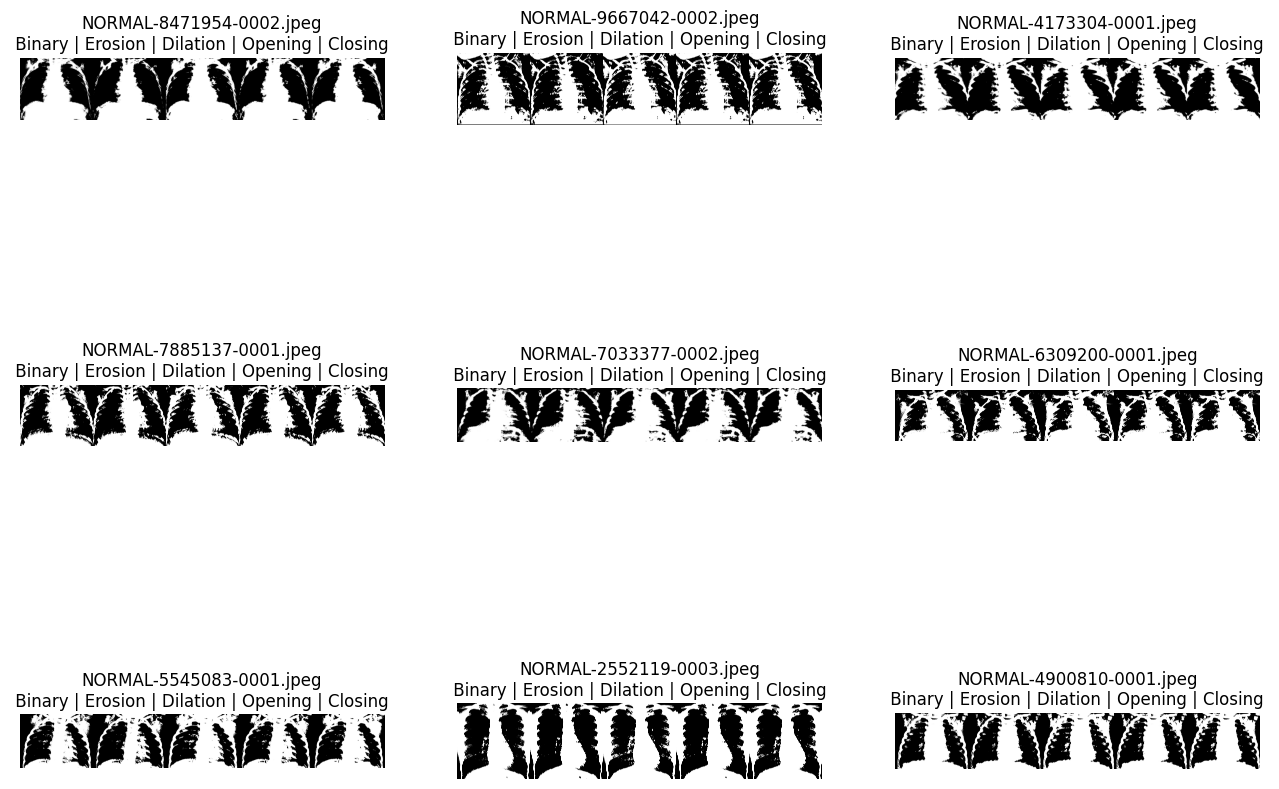

In [36]:
def apply_morphology(image):
    """ Morfolojik işlemleri uygula """
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))

    erosion = cv2.erode(image, kernel, iterations=1)
    dilation = cv2.dilate(image, kernel, iterations=1)
    opening = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)

    return erosion, dilation, opening, closing

fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for img_name, ax in zip(sample_images, axes.ravel()):
    img_path = os.path.join(data_dir, img_name)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    cropped_img = crop_fixed_percentage(img, crop_percentage=0.8)

    hist_eq_img = apply_histogram_equalization(cropped_img)

    _, binary_img = cv2.threshold(hist_eq_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    erosion, dilation, opening, closing = apply_morphology(binary_img)

    ax.imshow(np.hstack([binary_img, erosion, dilation, opening, closing]), cmap='gray')
    ax.axis("off")
    ax.set_title(f"{img_name}\n Binary | Erosion | Dilation | Opening | Closing ")

plt.show()


Connected Component Labeling - CCL işlemleri uygulanıyor.
Etiketlenen özellikler renkli olarak gösteriliyor.

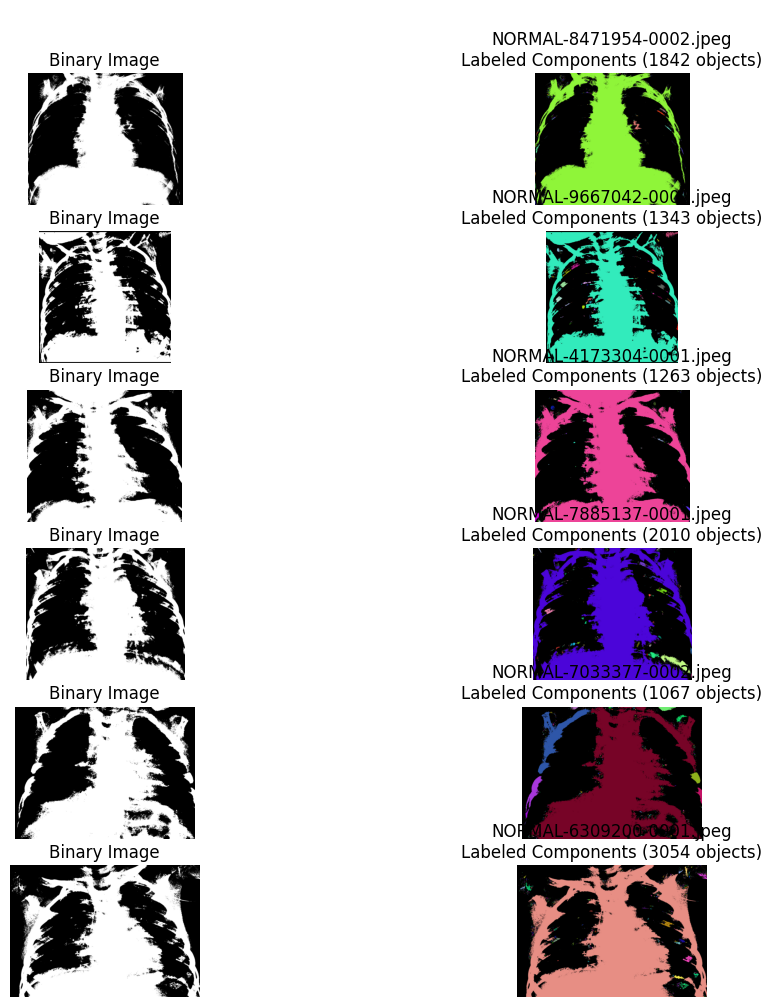

In [40]:
def apply_CCL(binary_image):
    """ Bağlantı Bileşen Analizi (Connected Component Labeling - CCL) uygula """
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_image, connectivity=8)
    return num_labels, labels, stats, centroids

fig, axes = plt.subplots(6, 2, figsize=(12, 12))

for img_name, ax_row in zip(sample_images, axes):
    img_path = os.path.join(data_dir, img_name)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    cropped_img = crop_fixed_percentage(img, crop_percentage=0.8)

    hist_eq_img = apply_histogram_equalization(cropped_img)

    _, binary_img = cv2.threshold(hist_eq_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    num_labels, labels, stats, centroids = apply_CCL(binary_img)

    label_img = np.zeros((*labels.shape, 3), dtype=np.uint8)
    for i in range(1, num_labels):  # 0. etiket arka plandır
        label_img[labels == i] = np.random.randint(0, 255, 3)

    ax_row[0].imshow(binary_img, cmap='gray')
    ax_row[0].axis("off")
    ax_row[0].set_title("Binary Image")

    ax_row[1].imshow(label_img)
    ax_row[1].axis("off")
    ax_row[1].set_title(f"\n{img_name}\nLabeled Components ({num_labels - 1} objects)")

plt.show()


Area, Perimeter, Solidity, Eccentricity, Mean Intensity ve Centroid öznitelikleri çıkarılıyor.

In [65]:
import skimage.measure

def extract_lung_features(segmented_img, label_img):
    """ Bağlantılı bileşenlerden akciğer bölgesine ait öznitelikleri çıkarır """

    properties = skimage.measure.regionprops(label_img, segmented_img)

    features = []
    for prop in properties:
        area = prop.area
        perimeter = prop.perimeter
        solidity = prop.solidity
        eccentricity = prop.eccentricity
        mean_intensity = prop.mean_intensity
        centroid = prop.centroid

        features.append({
            "Area": area,
            "Perimeter": perimeter,
            "Solidity": solidity,
            "Eccentricity": eccentricity,
            "Mean Intensity": mean_intensity,
            "Centroid": centroid
        })

    return features

for img_name in sample_images:
    img_path = os.path.join(data_dir, img_name)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    cropped_img = crop_fixed_percentage(img, crop_percentage=0.8)
    hist_eq_img = apply_histogram_equalization(cropped_img)
    _, binary_img = cv2.threshold(hist_eq_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_img, connectivity=8)

    lung_features = extract_lung_features(binary_img, labels)

    print(f"Görüntü: {img_name}")
    for i, feature in enumerate(lung_features):
        print(f"Bölge {i+1}: {feature}")

    print("-" * 50)


Görüntülenen çıkış son 5000 satıra kısaltıldı.
Bölge 4685: {'Area': 1.0, 'Perimeter': 0.0, 'Solidity': 1.0, 'Eccentricity': 0, 'Mean Intensity': 255.0, 'Centroid': (1123.0, 362.0)}
Bölge 4686: {'Area': 3.0, 'Perimeter': 1.0, 'Solidity': 1.0, 'Eccentricity': 1.0, 'Mean Intensity': 255.0, 'Centroid': (1122.0, 369.0)}
Bölge 4687: {'Area': 1.0, 'Perimeter': 0.0, 'Solidity': 1.0, 'Eccentricity': 0, 'Mean Intensity': 255.0, 'Centroid': (1122.0, 372.0)}
Bölge 4688: {'Area': 1.0, 'Perimeter': 0.0, 'Solidity': 1.0, 'Eccentricity': 0, 'Mean Intensity': 255.0, 'Centroid': (1122.0, 685.0)}
Bölge 4689: {'Area': 2.0, 'Perimeter': 0.0, 'Solidity': 1.0, 'Eccentricity': 1.0, 'Mean Intensity': 255.0, 'Centroid': (1123.5, 765.0)}
Bölge 4690: {'Area': 7.0, 'Perimeter': 7.242640687119285, 'Solidity': 0.7, 'Eccentricity': 0.9525998547492697, 'Mean Intensity': 255.0, 'Centroid': (1123.7142857142858, 828.7142857142857)}
Bölge 4691: {'Area': 4.0, 'Perimeter': 3.414213562373095, 'Solidity': 0.6666666666666666, 

Yukarıda elde edilen özniteliklerden En büyük alana sahip iki bölge için filtreleme işlemi yapılıyor.

In [66]:
def select_lung_regions(features, num_regions=2):
    """ Akciğer bölgelerini temsil eden en iyi alanları seç """

    sorted_features = sorted(features, key=lambda x: x["Area"], reverse=True)
    selected_regions = sorted_features[:num_regions]

    return selected_regions

for img_name in sample_images:
    img_path = os.path.join(data_dir, img_name)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    cropped_img = crop_fixed_percentage(img, crop_percentage=0.8)
    hist_eq_img = apply_histogram_equalization(cropped_img)
    _, binary_img = cv2.threshold(hist_eq_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    feature_list = extract_lung_features(binary_img, hist_eq_img)
    lung_regions = select_lung_regions(feature_list)

    lung_mask = np.zeros_like(binary_img)
    for region in lung_regions:
        lung_mask[binary_img == 255] = 255

    morphed_img = apply_morphology(lung_mask)
    segmented_img = cv2.bitwise_and(cropped_img, cropped_img, mask=morphed_img)

    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_img, connectivity=8)
    lung_features = extract_lung_features(binary_img, labels)

    selected_lungs = select_lung_regions(lung_features, num_regions=2)

    print(f"Görüntü: {img_name} için seçilen akciğer bölgeleri:")
    for i, feature in enumerate(selected_lungs):
        print(f"Bölge {i+1}: {feature}")

    print("-" * 50)


Görüntü: NORMAL-8471954-0002.jpeg için seçilen akciğer bölgeleri:
Bölge 1: {'Area': 415244.0, 'Perimeter': 26894.589016875114, 'Solidity': 0.5557750580878652, 'Eccentricity': 0.5815665270415237, 'Mean Intensity': 255.0, 'Centroid': (506.78074337016307, 475.6446739748196)}
Bölge 2: {'Area': 991.0, 'Perimeter': 508.0609665440988, 'Solidity': 0.4737093690248566, 'Eccentricity': 0.8694331281635935, 'Mean Intensity': 255.0, 'Centroid': (338.30575176589304, 649.7961654894046)}
--------------------------------------------------
Görüntü: NORMAL-9667042-0002.jpeg için seçilen akciğer bölgeleri:
Bölge 1: {'Area': 777873.0, 'Perimeter': 45293.3112628035, 'Solidity': 0.5185643688114604, 'Eccentricity': 0.6442834644786696, 'Mean Intensity': 255.0, 'Centroid': (742.4527461423652, 604.9076070258255)}
Bölge 2: {'Area': 2631.0, 'Perimeter': 1158.6793282948283, 'Solidity': 0.5993166287015945, 'Eccentricity': 0.9459118954250079, 'Mean Intensity': 255.0, 'Centroid': (29.35385784872672, 1194.9228430254657)

Filtre uygulanmış görüntü üzerine morfolojik işlemler tekrar uygulanıyor.
Sonrasında orijinal görüntü ile çarpılarak elde edilen görüntüler ekrana yazdırılıyor.

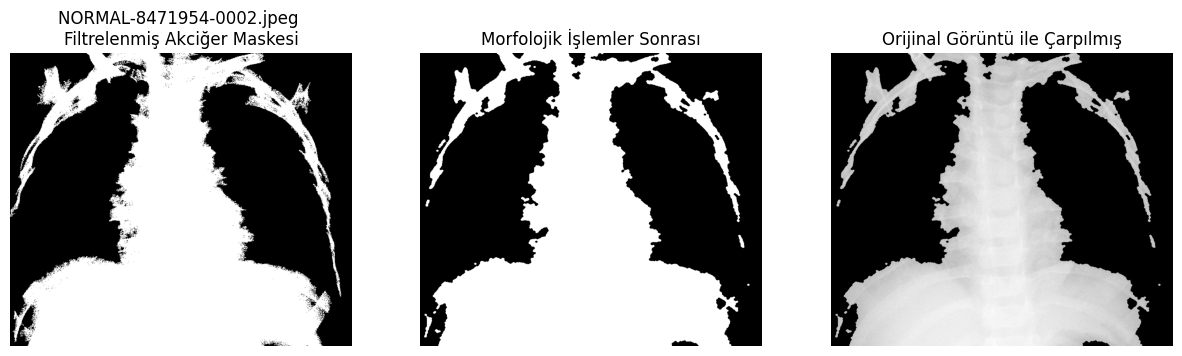

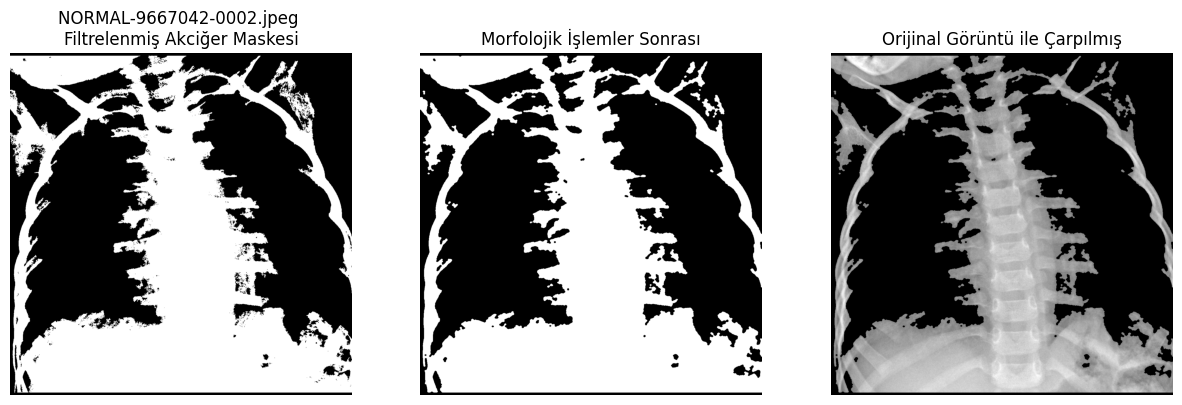

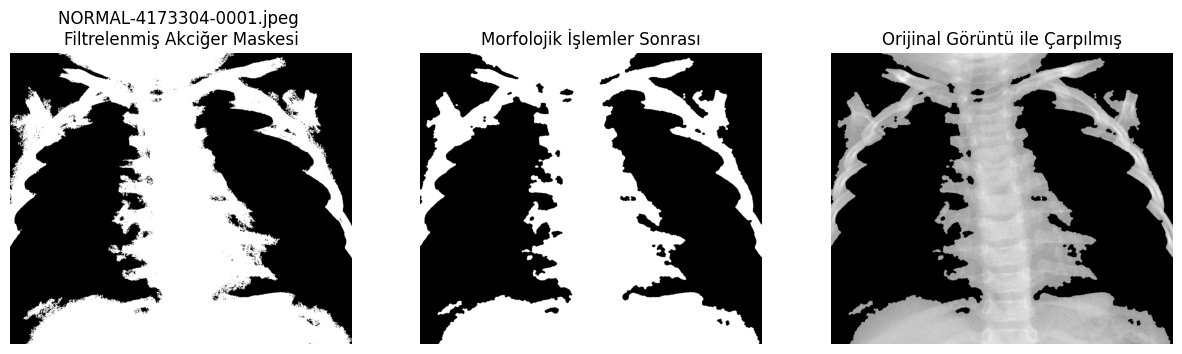

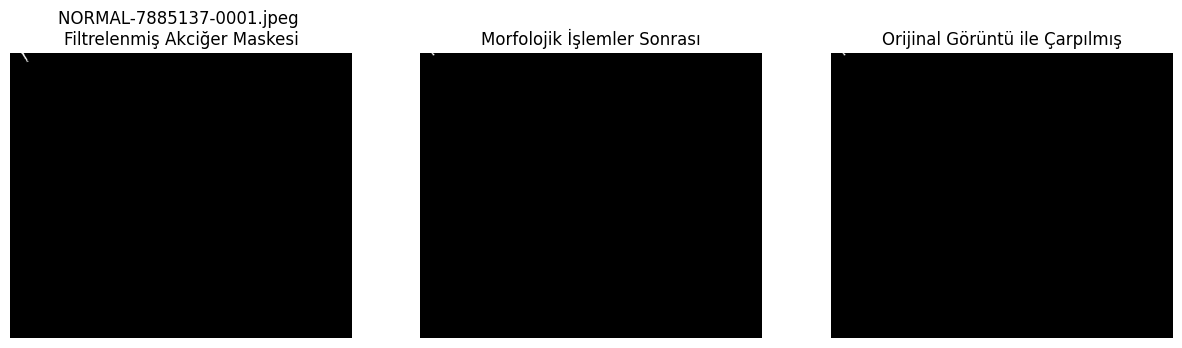

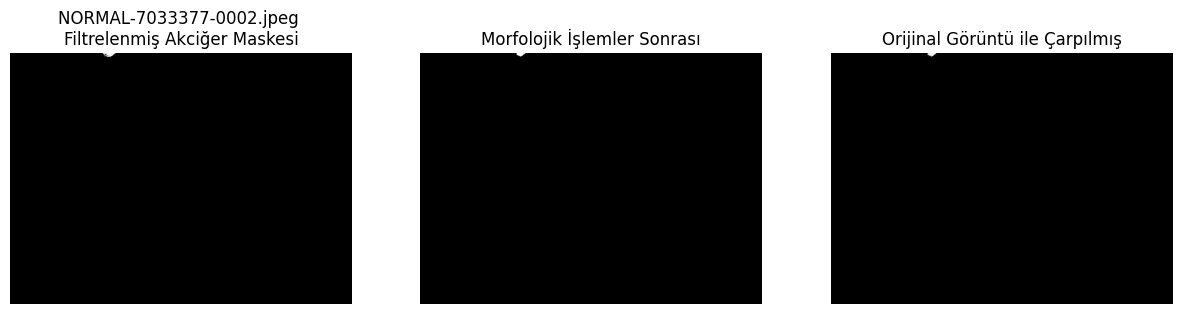

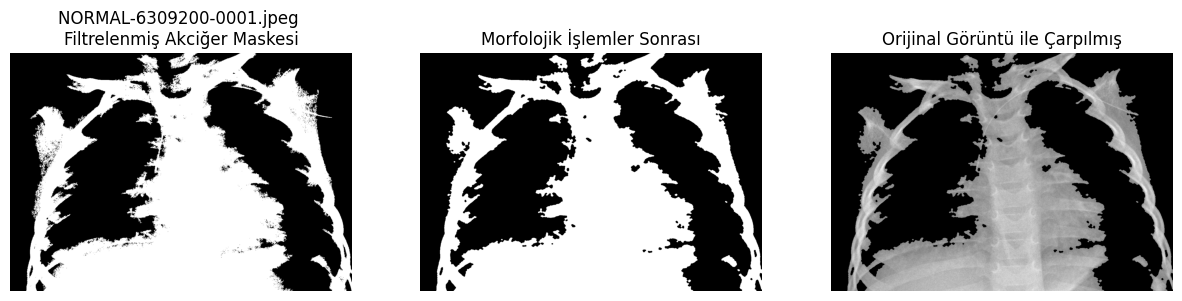

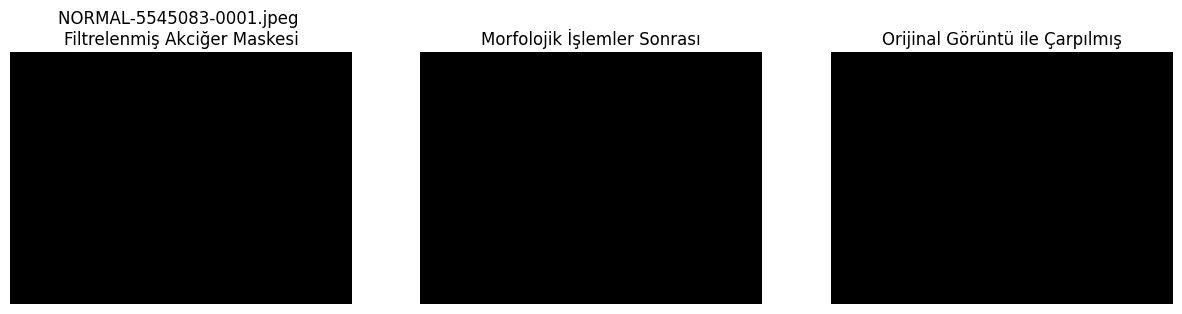

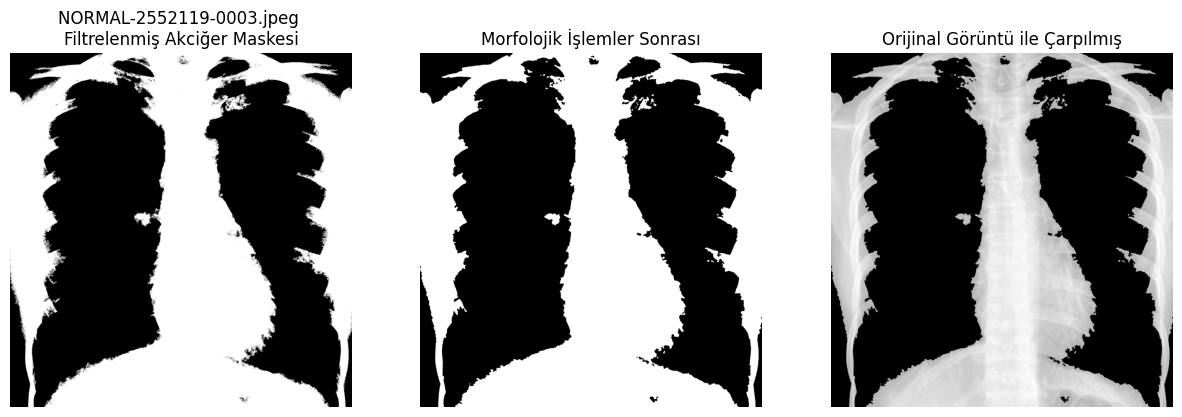

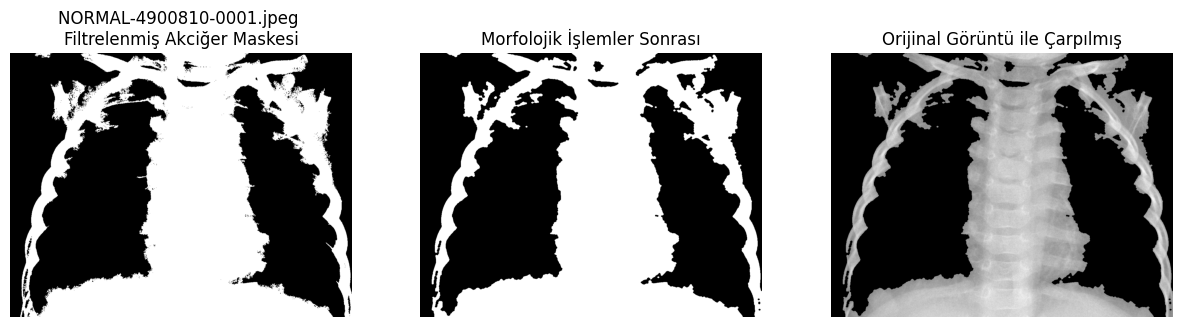

In [61]:
def apply_morphological_operations(mask, kernel_size=5):
    """ Seçilen akciğer bölgelerine uygun morfolojik işlemler uygula """

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    opened_mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    closed_mask = cv2.morphologyEx(opened_mask, cv2.MORPH_CLOSE, kernel)

    return closed_mask

for img_name in sample_images:
    img_path = os.path.join(data_dir, img_name)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    cropped_img = crop_fixed_percentage(img, crop_percentage=0.8)
    hist_eq_img = apply_histogram_equalization(cropped_img)
    _, binary_img = cv2.threshold(hist_eq_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    feature_list = extract_lung_features(binary_img, hist_eq_img)
    lung_regions = select_lung_regions(feature_list)

    lung_mask = np.zeros_like(binary_img)
    for region in lung_regions:
        lung_mask[binary_img == 255] = 255

    morphed_img = apply_morphology(lung_mask)
    segmented_img = cv2.bitwise_and(cropped_img, cropped_img, mask=morphed_img)

    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_img, connectivity=8)

    lung_features = extract_lung_features(binary_img, labels)
    selected_lungs = select_lung_regions(lung_features, num_regions=2)

    filtered_mask = np.zeros_like(binary_img)
    for i, region in enumerate(selected_lungs):
        filtered_mask[labels == i+1] = 255

    final_mask = apply_morphological_operations(filtered_mask, kernel_size=7)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(filtered_mask, cmap='gray')
    axes[0].set_title(f"{img_name} \nFiltrelenmiş Akciğer Maskesi")
    axes[0].axis("off")

    axes[1].imshow(final_mask, cmap='gray')
    axes[1].set_title("Morfolojik İşlemler Sonrası")
    axes[1].axis("off")

    axes[2].imshow(cv2.bitwise_and(cropped_img, cropped_img, mask=final_mask), cmap='gray')
    axes[2].set_title("Orijinal Görüntü ile Çarpılmış")
    axes[2].axis("off")

    plt.show()


# Değerlendirme

*   3 görüntüde tamamen siyaha yakın görüntü elde etmemin nedenleri muhtemelen uyguladığım filtreleme sonucu tüm pikseller kayboldu. Bir diğer neden de uygulanan morfolojik işlemler olabilir. Yine bağlantı bileşeninin yanlış seçilmiş olması da olabilir.
*   Diğer görüntülerde elde ettiğim görüntüleri değerlendirecek olursam, genelde başarılı bir segmentasyon yapılmış diyebiliriz. Ama iç kısımlarda kalan beyazlıklar bazı hataları da gösteriyor. Seçilen eşik değerlerinde yada uygulanan morfolojik işlemlerde düzeltmeler ile daha iyi sonuçlar alınabilir.

